# Homework for statistics module

Rules for code style:
* All the code in this notebook
* Imports are provided in the head of the notebook
* All the cells could be ran in the right order from the top to the bottom
* Commentaries are required
* All the plots should have: title, axis labels and summaries (if necessary)
* Main summaries are provided in cells using markdown **(your analysis of the results and data is very important!!!)**
* Try to use functions and classes to reduce duplicated code blocks to minimum

Also you can use $\LaTeX$ to write formulas. F.e. $\bar{y} = \frac{1}{n}\sum_{i=1}^n \hat{x}_i$ or on a new line:
$$
    \bar{y} = \frac{1}{n}\sum_{i=1}^n \hat{x}_i
$$
To do so, you can write anything between $\$ \quad \$$ (or  $ \$\$ \quad\$\$ $).

### Evaluation criteria (100% in total)
## Task 1 (30% max)
1. Requested formulas are provided (5%)
2. All necessary experiments are done (10%)
3. Results are analysed with commentaries (15%)

## Tasks 2.1 и 2.2 (40% max)
1. Visualization and/or simple exploratory data analysis are implemented (5% * 2 tasks)
2. Hypotheses are tested (5% * 2 tasks)
3. Results are analysed with commentaries (10%*2 tasks)

## Task 3 (25% max)
1. Visualization and/or simple exploratory data analysis are implemented (5%)
2. Hypotheses are tested (5%)
3. Data was aggregated properly (5%)
4. Results are analysed with commentaries (10%)

### Extra points (5% max)
1. +5% in case clear, "pythonic" and understandable code style


In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as st
import math

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
plt.style.use('bmh')

from pylab import rcParams

# plots in svg look more precise
%config InlineBackend.figure_format = 'svg'

# Task 1

## Stratification

The example:

Let's assume, we need to estimate a mean votes count for every election candidate. Suppose there are 3 cities in a country: 1 million factory workers live in city A, 2 million office workers live in city B, and 3 million senior citizens live in city C. We can choose a random sample of 60 votes from the entire population, but there is some chance that the random sample will be poorly balanced between these cities and, therefore, will be biased and of little use ("average temperature in the hospital"), causing a significant error in the estimation. Instead, if we choose to use a simple random sample of 10, 20 and 30 votes from cities A, B and C, respectively, we can get a smaller error in the estimate with the same total sample size. This technique is called stratification.


### The task

Suppose the population is a mixture of 3 normally distributed CBs. In other words, the population can be divided into 3 strata.
$$
    F(X) = a_1 F(X_1) + a_2 F(X_2) + a_3 F(X_3)
$$

**Goals:**  

1. Derive (for example, in the block below, using Markdown) the formulas for point estimates of the mathematical expectation and variance for the average value of subsamples formed in different ways:
- random selection from the entire population;
- random selection of strata in proportion to strata volumes;
- random selection according to the optimal sub-sampling.

2. Calculate point estimates of the mathematical expectation and variance of the mean value for each data sampling method from p.1, provided:
* Experiments should be conducted for 3 cases (for every method from p.1 each):
     * all strata have the same mat. expectations and variance;
     * strata have different mat. expectations, but the same variance;
     * strata have different mat. expectations and variance.
* For each experiment plot histogram of General Population data (using matplotlib or seaborn packages);
* Plot boxplots for sample mean estimated using each sampling method on a single figure to compare the results. Repeat for each experiment.
* You are provided with `GeneralPopulation` class. It already has all necessary methods for sampling and creating general population as a mixture of strata.
* Your goal is to write functions to conduct experiments and visualize the results.   
* Also provide commentaries as summaries and analysis of results after each visualization.


## Solution for Task 1

### Formulas:

#### Stratified sample point estimations:

Mean:

$$\hat{X}_k = \frac{1}{n_k}\sum^{n_k}_{i=1}X_{ik}$$

Variance:

$$\hat{X}_k = \frac{1}{n_k}\sum^{n_k}_{i=1}(X_{ik}-\hat{X}_k)^2$$



#### Sample volumes if they are sampled proportionally:

Expected Value of mixture sample mean:

$$\mu = \sum_{k=1}^LW_{k}\mu_k \Rightarrow \hat{X}_S = \sum_{k=1}^LW_k\hat{X}_k$$

$$E\bar{X}_S = \sum^L_{k = 1}W_k E \bar{X}_k = \sum^L_{k = 1}W_k \mu_k$$

Variance:

$$D^*_S = \sum^L_{k=1}W_kD_k^* + \sum^L_{k=1}W_k(\sum^L_{i=1}W_i\hat{X}_i-\hat{X}_k)^2$$

#### Sample volumes if they are optimal sampled (Neyman's method):

$$\hat{n}_k = n \frac{W_k \sigma_k}{\sum^L_{k=1}W_k \sigma_k}, k = \bar{1}\bar{L}, n = n_1 + ... + n_L$$

---

**GeneralPopulation class**  
Already has methods for creating general population as a mixture of strata, for generating subsample with random, optimal and stratified techniques:

In [ ]:
class GeneralPopulation:

  def __init__(self, 
               means: [float], 
               stds: [float], 
               sizes: [int], 
               random_state: int = 15
               ):
    """
    Initializes our General Population and saves the given distributions
    
    :param means: List of expectations for normal distributions
    :param stds: List of standard deviations for normal distributions
    :param sizes: How many objects will be in each strata
    :param random_state: Parameter fixing randomness. Needed so that when conducting
    experiment repeatedly with the same input parameters, the results remained the same
    """
    self.strats = [st.norm(mean, std) for mean, std in zip(means, stds)]
    self._sample(sizes)
    self.random_state = random_state

  def _sample(self, sizes):
        """Creates a general population sample as a mixture of strata
        
        :param sizes: List with sample sizes of the corresponding normal distributions
        """
        self.strats_samples = [rv.rvs(size) for rv, size in zip(self.strats, sizes)]
        self.general_samples = np.hstack(self.strats_samples)
        self.N = self.general_samples.shape[0]
        
        # number of strata
        self.count_strats = len(sizes)
        
        # ratios for every strata in GP
        self.ws = [size/self.N for size in sizes]
        
        # ME and Std for GP
        self.m = np.mean(self.general_samples)
        self.sigma = np.std(self.general_samples)
        
        # ME and std for all strata
        self.ms = [np.mean(strat_sample) for strat_sample in self.strats_samples]
        self.sigmas = [np.std(strat_sample) for strat_sample in self.strats_samples]

  def random_subsampling(self, size):
      """Creates a random subset of the entire population
      
      :param sizes: subsample size
      """
      rc = np.random.choice(self.general_samples, size=size) 
      return rc
      
  def proportional_subsampling(self, size):
      """Creates a subsample with the number of elements, proportional shares of strata
      
      :param sizes: subsample size
      """
      self.strats_size_proport = [int(np.floor(size*w)) for w in self.ws]
      
      rc = []
      for k in range(len(self.strats_size_proport)):
          rc.append(np.random.choice(self.strats_samples[k],
                                      size=self.strats_size_proport[k]))
      
      return rc
      
  def optimal_subsampling(self, size):
      """Creates a subsample with the optimal number of elements relative to strata
      
      :param sizes: subsample size
      """
      sum_denom = 0
      for k in range(self.count_strats):
          sum_denom += self.ws[k] * self.sigmas[k]
      
      self.strats_size_optimal = [int(np.floor((size*w*sigma)/sum_denom)) for w, sigma in zip(self.ws, self.sigmas)]
      if 0 in self.strats_size_optimal:
          raise ValueError('Strats size is 0, please change variance of smallest strat!')
      
      rc = []
      for k in range(len(self.strats_size_optimal)):
          rc.append(np.random.choice(self.strats_samples[k],
                                      size=self.strats_size_optimal[k]))
      
      return rc   

  def run_experiments(self, n_sub, subsampling_method, n_experiments=1000):
      """Conducts a series of experiments and saves the results
      
      :param subsampling_method: method for creating a subsample
      :param n_experiments: number of experiment starts
      """
      means_s = []
      
      if(len(self.general_samples)<100):
          n_sub = 20
      
      if(subsampling_method == 'random_subsampling'):
          for n in range(n_experiments):
              rc = self.random_subsampling(n_sub)
              
              mean = rc.sum()/len(rc)
              means_s.append(mean)
              
      else:
          for n in range(n_experiments):
              if(subsampling_method == 'proportional_subsampling'):
                  rc = self.proportional_subsampling(n_sub)
              elif(subsampling_method == 'optimal_subsampling'):
                  rc = self.optimal_subsampling(n_sub)
              
              strats_mean = []
      
              for k in range(len(rc)):
                  strats_mean.append(sum(rc[k])/len(rc[k]))
      
              # Mean for a mixture
              means_s.append(sum([w_k*mean_k for w_k, mean_k in zip(self.ws, strats_mean)]))
              
      return means_s

Function for histogram plot:

In [ ]:
"""HERE IS YOUR CODE
It should be implemented as follows:
* Takes a GeneralPopulation class instance;
* Uses matplotlib or seaborn packages to plot distribution for general population;
* Don't forget a title, grid etc. 
"""

def my_histogram(instance, case):
  fig, ax = plt.subplots(figsize = (8, 4))
  sns.histplot(data = instance.general_samples)
  plt.title(f'General population in case: {case}')
  plt.show()


Function for plotting Boxplots for sample mean:

In [ ]:
"""HERE IS YOUR CODE
It should be implemented as follows:
* Takes a GeneralPopulation class instance;
* Runs method `run_experiments` for each sampling method and gets vector of mean values;
* Uses matplotlib or seaborn packages to plot boxplots of mean values for each subsampling techniques;
* Axis Y == Mean values; Axis X == subsampling methods;
* Don't forget a title, grid etc. 
"""

def my_boxplot(instance, case):
  x1 = instance.run_experiments(N_SUBSAMPLE, 'random_subsampling')
  x2 = instance.run_experiments(N_SUBSAMPLE, 'proportional_subsampling')
  x3 = instance.run_experiments(N_SUBSAMPLE, 'optimal_subsampling')
  fig, ax = plt.subplots(figsize = (10, 5))
  sns.boxplot(data = [x1, x2, x3])
  ax.set_title(f'General population in case: {case}')
  ax.set_xticklabels(['Random sampling', 'Proportional sampling', 'Optimal sampling'])
  plt.show()

**Initialization**

**Parameters for each General Population**  
You can use these or specify your own parameters for strata:

In [ ]:
SIZES = (150, 150, 150)
N_SUBSAMPLE = 150
EQUAL_MEAN_EQUAL_STDS_ARGS = {'means': [0, 0, 0], 'stds': [3, 3, 3], 'sizes': SIZES}
DIFFERENT_MEAN_EQUAL_STDS_ARGS = {'means': [15, -1, -17], 'stds': [3, 3, 3], 'sizes':SIZES}
# EQUAL_MEAN_DIFFERENT_STDS_ARGS = {'means': [0, 0, 0], 'stds': [3, 7, 11], 'sizes':SIZES}    # Task description: 'different mat. expectations and variance'
DIFFERENT_MEAN_DIFFERENT_STDS_ARGS = {'means': [1, 3, 5], 'stds': [3, 7, 11], 'sizes':SIZES}

In [ ]:
case_1 = GeneralPopulation(**EQUAL_MEAN_EQUAL_STDS_ARGS)
case_2 = GeneralPopulation(**DIFFERENT_MEAN_EQUAL_STDS_ARGS)
case_3 = GeneralPopulation(**DIFFERENT_MEAN_DIFFERENT_STDS_ARGS)

## Plotting

### **General population with EQUAL means and EQUAL STDs of strata**  
Distribution histogram:

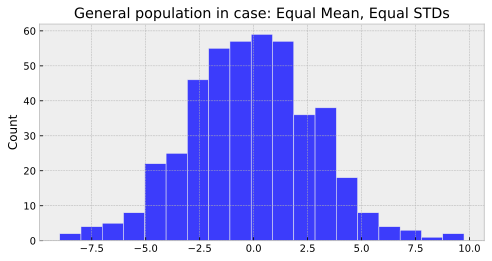

In [ ]:
# Run plotting for density
my_histogram(case_1, 'Equal Mean, Equal STDs')

Here we can see, that the points are mainly focused at -3 to 3, this is because the mean value is 0, and the stds are 3 in all cases. So most of the values will be in this range.

Boxplots for sample mean:

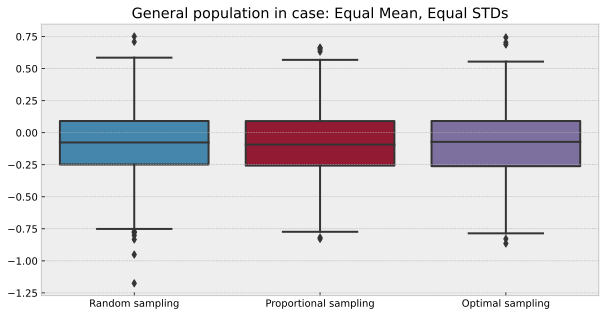

In [ ]:
# Run plotting for boxplots
my_boxplot(case_1, 'Equal Mean, Equal STDs')

There is not much difference as it seems on the boxplots in case Equal Means and Equal STD-s between the sampling methods. EV and Variances are equal.

### **General population with DIFFERENT means and EQUAL STDs of strata**  
Distribution histogram:

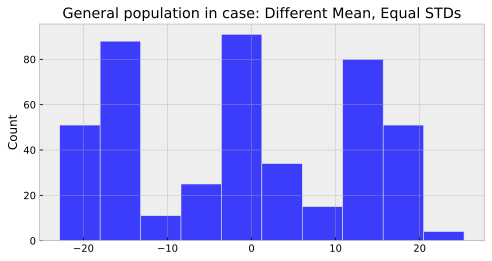

In [ ]:
# Run plotting for density
my_histogram(case_2, 'Different Mean, Equal STDs')

The histogram at first sight might be strange, but the mean values now are -17, -1 and 15, and the stds are 3-3-3.

Boxplots for sample mean:

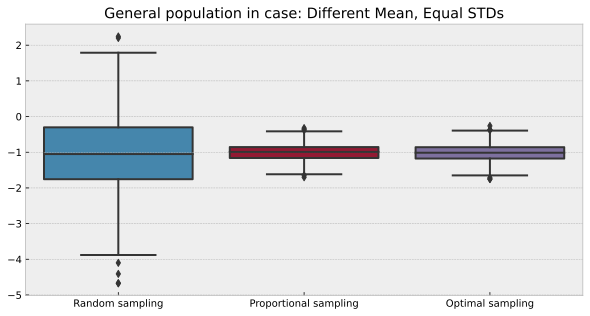

In [ ]:
# Run plotting for boxplots
my_boxplot(case_2, 'Different Mean, Equal STDs')

Now it's very clear that the variance is so much smaller with proportional and optimal sampling methods then random sampling. They are working better, if the means are different, but the stds are equal.

### **General population with DIFFERENT means and DIFFERENT STDs of strata**  
Distribution histogram:

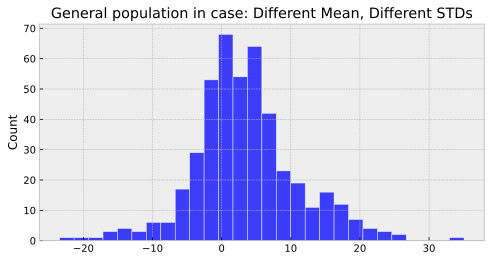

In [ ]:
# Run plotting for density
my_histogram(case_3, 'Different Mean, Different STDs')

Means are 1, 3, 5, stds are 3, 7, 11.
The histogram shows that most of the values concentrated in -3 to 8.

Boxplots for sample mean:

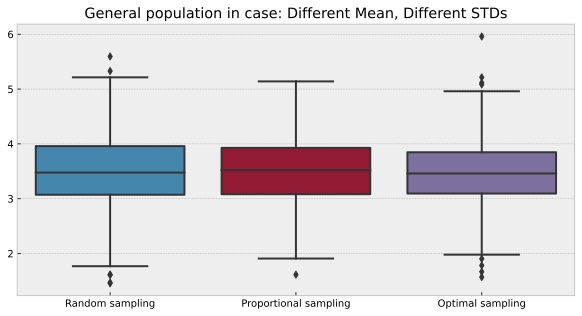

In [ ]:
# Run plotting for boxplots
my_boxplot(case_3, 'Different Mean, Different STDs')s

Maybe hard to see, but Optimal sampling's boxplot has the lowest interquantile range. I think this means it's more precise, then the other sampling methods.

---

# Task 2



### Part 1
Using [this criteria](https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/how-to/correlation/interpret-the-results/#:~:text=For%20the%20Pearson%20correlation%2C%20an,linear%20relationship%20between%20the%20variables.&text=If%20both%20variables%20tend%20to,represents%20the%20correlation%20slopes%20upward.), check whether there is a correlation between a brain size and intelligence for a dataset consisted both of men and women objects. Also check it for men and women subsamples separately.


### Part 2
Using $Chi^2$ criteria check whether there is a statistical difference between men's and women's choice of auto.  (Features `Sex` и `PreferCar`)


You can download dataset using the following:

In [ ]:
!pip install bds_courseware

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from bds_courseware import read_drive_dataset
from bds_courseware import HOMEWORK_DATASETS
brain_data = read_drive_dataset(*HOMEWORK_DATASETS['brain'])  # PART 1
cars_prefes_data = read_drive_dataset(*HOMEWORK_DATASETS['car_perfs'])  # PART 2

## Brain data EDA, DP

In [ ]:
brain_data.head()

,Gender,FSIQ,VIQ,PIQ,Weight,Height,MRI_Count
0,Female,133,132,124,118,64.5,816932
1,Male,140,150,124,�,72.5,1001121
2,Male,139,123,150,143,73.3,1038437
3,Male,133,129,128,172,68.8,965353
4,Female,137,132,134,147,65.0,951545


In [ ]:
brain_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Gender     40 non-null     object
 1   FSIQ       40 non-null     int64 
 2   VIQ        40 non-null     int64 
 3   PIQ        40 non-null     int64 
 4   Weight     40 non-null     object
 5   Height     40 non-null     object
 6   MRI_Count  40 non-null     int64 
dtypes: int64(4), object(3)
memory usage: 2.3+ KB


In [ ]:
brain_data.isna().sum()

Gender       0
FSIQ         0
VIQ          0
PIQ          0
Weight       0
Height       0
MRI_Count    0
dtype: int64

In [ ]:
brain_data.dtypes

Gender       object
FSIQ          int64
VIQ           int64
PIQ           int64
Weight       object
Height       object
MRI_Count     int64
dtype: object

In [ ]:
brain_data.Weight.unique()

array(['118', '�', '143', '172', '147', '146', '138', '175', '134', '151',
       '155', '135', '127', '178', '136', '180', '186', '122', '132',
       '114', '171', '140', '187', '106', '159', '191', '192', '181',
       '153', '144', '139', '148', '179'], dtype=object)

In [ ]:
brain_data.Height.unique()

array(['64.5', '72.5', '73.3', '68.8', '65.0', '69.0', '66.0', '66.3',
       '70.0', '70.5', '68.0', '68.5', '73.5', '�', '76.5', '62.0',
       '63.0', '72.0', '77.0', '66.5', '62.5', '67.0', '75.5', '74.0'],
      dtype=object)

In [ ]:
# Calculate and replace the nan value to the mean

weight_mean = []
height_mean = []

for item in brain_data.Weight:
    try:
      weight_mean.append(int(item))
    except:
      continue

for item in brain_data.Height:
  try:
    height_mean.append(float(item))
  except:
    continue

In [ ]:
weight_mean = int(sum(weight_mean) / len(weight_mean))
height_mean = sum(height_mean) / len(height_mean)

print('Weight mean:', weight_mean)
print('Height mean:', height_mean)

Weight mean: 151
Height mean: 68.52564102564102


In [ ]:
brain_data.Weight.replace('�', weight_mean, inplace = True)
brain_data.Height.replace('�', height_mean, inplace = True)

In [ ]:
# change the dtype
brain_data.Weight = brain_data.Weight.astype('int64')
brain_data.Height = brain_data.Height.astype('float64')

In [ ]:
brain_data.describe()

,FSIQ,VIQ,PIQ,Weight,Height,MRI_Count
count,40.000000,40.000000,40.00000,40.000000,40.000000,4.000000e+01
mean,113.450000,112.350000,111.02500,151.050000,68.525641,9.087550e+05
std,24.082071,23.616107,22.47105,22.868577,3.943103,7.228205e+04
min,77.000000,71.000000,72.00000,106.000000,62.000000,7.906190e+05
25%,89.750000,90.000000,88.25000,135.750000,66.000000,8.559185e+05
50%,116.500000,113.000000,115.00000,147.500000,68.250000,9.053990e+05
75%,135.500000,129.750000,128.00000,172.000000,70.500000,9.500780e+05
max,144.000000,150.000000,150.00000,192.000000,77.000000,1.079549e+06


Basically, `Weight` and `Height` feature are irrelevant in this case, so if no calculations need furthermore, it could be dropped.

In [ ]:
# Separate the genders
brain_data_m = brain_data[brain_data['Gender'] == 'Male']
brain_data_f = brain_data[brain_data['Gender'] == 'Female']

In [ ]:
# Check for the outliers
for col in brain_data.select_dtypes('number').columns:
  q = brain_data[f'{col}'].quantile(0.95)
  print(col, 'Number of outliers:', (brain_data[f'{col}'][brain_data[f'{col}'] > q]).count())

FSIQ Number of outliers: 1
VIQ Number of outliers: 0
PIQ Number of outliers: 1
Weight Number of outliers: 2
Height Number of outliers: 2
MRI_Count Number of outliers: 2


### Correlations between Brain size and IQ-s

In [ ]:
from scipy.stats import pearsonr

# MRI Count for brain size
mri_count = brain_data['MRI_Count']
# Get the IQ-s
iqs = brain_data[['FSIQ', 'VIQ', 'PIQ']]

for iq in iqs:
  corr, _ = pearsonr(mri_count, brain_data[f'{iq}'])
  print(iq, corr)

FSIQ 0.35764096936905665
VIQ 0.33747772802033543
PIQ 0.3868173150245029


FSIQ is based on VIQ and PIQ, but for be confident, I analyze all of them.

Hypothesis testing for this task (I'm not sure, if it's necessary, so I'll just do it for this case, where I analyze the whole dataset)

In [ ]:
df = mri_count.shape[0]
df

38

From Pearson's Correlation Table, the degree of freedom is 38.

$critical$ $value is around: 0.31$

If our calculated $r > cricital$ $value$, we reject the null hypothesis.

All of our calculated perason r value is greater than 0.31,

so we reject $H_0$: The brain size and IQ level are independent.

accept $H_1$: The Brain size and IQ level are dependent.

In [ ]:
# Let's check if I drop the outliars
for col in brain_data.select_dtypes('number').columns:
  q = brain_data[f'{col}'].quantile(0.95)
  brain_data_filtered = brain_data[brain_data[f'{col}'] < q]

print(f'{len(brain_data) - len(brain_data_filtered)} row(s) removed.')

2 row(s) removed.


In [ ]:
mri_count = brain_data_filtered['MRI_Count']
iqs = brain_data_filtered[['FSIQ', 'VIQ', 'PIQ']]

for iq in iqs:
  corr, _ = pearsonr(mri_count, brain_data_filtered[f'{iq}'])
  print(iq, corr)

FSIQ 0.37055898378750785
VIQ 0.3369304946493956
PIQ 0.40334660544219925


The correlation is a bit higher in FSIQ and PIQ features without the outliers.

The ~0.34 - ~0.4 pearson coefficient shows a moderate, positive relationship between the IQ-s and Brain sizes.

This means if one of them increases, the other is likely to also increase, but not necessarily at a constant rate.

The size of the brain explains ~ 35% of the intelligence.

#### Within Genders

In [ ]:
# Check the correlations within genders Female and Male.

mri_count_f = brain_data['MRI_Count'][brain_data['Gender'] == 'Female']
iqs_f = brain_data[['FSIQ', 'VIQ', 'PIQ']][brain_data['Gender'] == 'Female']

mri_count_m = brain_data['MRI_Count'][brain_data['Gender'] == 'Male']
iqs_m = brain_data[['FSIQ', 'VIQ', 'PIQ']][brain_data['Gender'] == 'Male']

**Female**

In [ ]:
for iq in iqs_f:
  corr, _ = pearsonr(mri_count_f, iqs_f[f'{iq}'])
  print(iq, corr)

FSIQ 0.3256967004963704
VIQ 0.2549328529614766
PIQ 0.39615716686847646


Pearson coefficients are not so strong, these numbers also shows a relatively moderate, positive relationship between MRI Count and IQ-s.

The VIQ (Verbal Intelligence Quotient) has the lowest relationship with the brain size.

**Male**

In [ ]:
for iq in iqs_m:
  corr, _ = pearsonr(mri_count_m, iqs_m[f'{iq}'])
  print(iq, corr)

FSIQ 0.49836911041719256
VIQ 0.4131049601428286
PIQ 0.5682370032144156


It can be seen really well, that for the gender Male, the brain size is more likely to follow the IQ-s, than the gender Female.

0.49, 0.41, 0.57 is obviously higher then the Female's pearson coefficients.



---



## Cars Prefes Data EDA, DP

In [ ]:
cars_prefes_data.head()

,Age,Sex,LicYr,LicMth,ActCar,Kids5,Kids6,PreferCar,Car15K,Reason,...,Reliable,Perform,Fuel,Safety,AC/PS,Park,Room,Doors,Prestige,Colour
0,18,2,0,2,3,2,2,2,2,1,...,4,3,3,3,3,3,3,3,3,2
1,25,1,8,0,1,2,2,1,1,1,...,4,4,4,4,3,4,4,2,3,3
2,63,2,46,0,3,2,2,3,2,5,...,3,3,3,3,3,3,3,3,3,3
3,51,1,35,0,3,2,2,2,2,1,...,3,3,3,4,3,3,3,3,1,3
4,19,1,2,0,2,2,2,2,1,6,...,3,4,3,3,2,3,3,2,3,3


In [ ]:
cars_prefes_data.columns

Index(['Age', 'Sex', 'LicYr', 'LicMth', 'ActCar', 'Kids5', 'Kids6',
       'PreferCar', 'Car15K', 'Reason', 'Cost', 'Reliable', 'Perform', 'Fuel',
       'Safety', 'AC/PS', 'Park', 'Room', 'Doors', 'Prestige', 'Colour'],
      dtype='object')

In [ ]:
cars_prefes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 21 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Age        300 non-null    int64
 1   Sex        300 non-null    int64
 2   LicYr      300 non-null    int64
 3   LicMth     300 non-null    int64
 4   ActCar     300 non-null    int64
 5   Kids5      300 non-null    int64
 6   Kids6      300 non-null    int64
 7   PreferCar  300 non-null    int64
 8   Car15K     300 non-null    int64
 9   Reason     300 non-null    int64
 10  Cost       300 non-null    int64
 11  Reliable   300 non-null    int64
 12  Perform    300 non-null    int64
 13  Fuel       300 non-null    int64
 14  Safety     300 non-null    int64
 15  AC/PS      300 non-null    int64
 16  Park       300 non-null    int64
 17  Room       300 non-null    int64
 18  Doors      300 non-null    int64
 19  Prestige   300 non-null    int64
 20  Colour     300 non-null    int64
dtypes: int64(21)
mem

In [ ]:
cars_prefes_data.describe()

,Age,Sex,LicYr,LicMth,ActCar,Kids5,Kids6,PreferCar,Car15K,Reason,...,Reliable,Perform,Fuel,Safety,AC/PS,Park,Room,Doors,Prestige,Colour
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.00000,300.000000,300.00000,...,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,34.123333,1.500000,15.240000,0.620000,2.000000,1.903333,1.736667,2.17000,1.536667,2.93000,...,3.830000,3.336667,3.293333,3.576667,2.876667,2.716667,2.990000,2.546667,2.100000,2.186667
std,15.344695,0.500835,14.424376,1.995547,0.817861,0.295997,0.441178,0.86618,0.499487,1.69746,...,0.393637,0.681815,0.664903,0.631494,1.002400,0.905052,0.738275,1.008901,0.897786,0.928095
min,18.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.00000,...,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,21.000000,1.000000,3.000000,0.000000,1.000000,2.000000,1.000000,2.00000,1.000000,1.00000,...,4.000000,3.000000,3.000000,3.000000,2.000000,2.000000,3.000000,2.000000,1.000000,1.000000
50%,27.000000,1.500000,9.000000,0.000000,2.000000,2.000000,2.000000,2.00000,2.000000,3.00000,...,4.000000,3.000000,3.000000,4.000000,3.000000,3.000000,3.000000,3.000000,2.000000,2.000000
75%,46.000000,2.000000,26.000000,0.000000,3.000000,2.000000,2.000000,3.00000,2.000000,4.00000,...,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000
max,75.000000,2.000000,57.000000,11.000000,3.000000,2.000000,2.000000,4.00000,2.000000,6.00000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000


In [ ]:
cars_prefes_data.isna().sum()

Age          0
Sex          0
LicYr        0
LicMth       0
ActCar       0
Kids5        0
Kids6        0
PreferCar    0
Car15K       0
Reason       0
Cost         0
Reliable     0
Perform      0
Fuel         0
Safety       0
AC/PS        0
Park         0
Room         0
Doors        0
Prestige     0
Colour       0
dtype: int64

In [ ]:
cars_prefes_data['Sex'].unique()

array([2, 1])

In [ ]:
cars_prefes_data['Sex'].value_counts()

2    150
1    150
Name: Sex, dtype: int64

In [ ]:
cars_prefes_data['PreferCar'].unique()

array([2, 1, 3, 4])

In [ ]:
cars_prefes_data['PreferCar'].value_counts()

2    136
3     73
1     68
4     23
Name: PreferCar, dtype: int64

Sex
- 1 = male
- 2 = female

### Hypothesis test

Hyptohesis
- H0: There is no statistical difference between female and males car preference. (They are independent)
- H1: There is a difference.

Task said only work with feature "Sex" and "PreferCar".

In [ ]:
# So let's take out these two features
cars_prefers = pd.DataFrame()
cars_prefers['Sex'] = cars_prefes_data['Sex']
cars_prefers['PreferCar'] = cars_prefes_data['PreferCar']

cars_prefers.head()

,Sex,PreferCar
0,2,2
1,1,1
2,2,3
3,1,2
4,1,2


In [ ]:
contigency = pd.crosstab(cars_prefers['Sex'], cars_prefers['PreferCar'])
contigency

PreferCar,1,2,3,4
Sex,,,,
1,43,75,26,6
2,25,61,47,17


These are the frequences of PreferCar by Sex

In [ ]:
contigency_pct = pd.crosstab(cars_prefers['Sex'], cars_prefers['PreferCar'], normalize='index')
contigency_pct

PreferCar,1,2,3,4
Sex,,,,
1,0.286667,0.500000,0.173333,0.040000
2,0.166667,0.406667,0.313333,0.113333


These are the percentages.

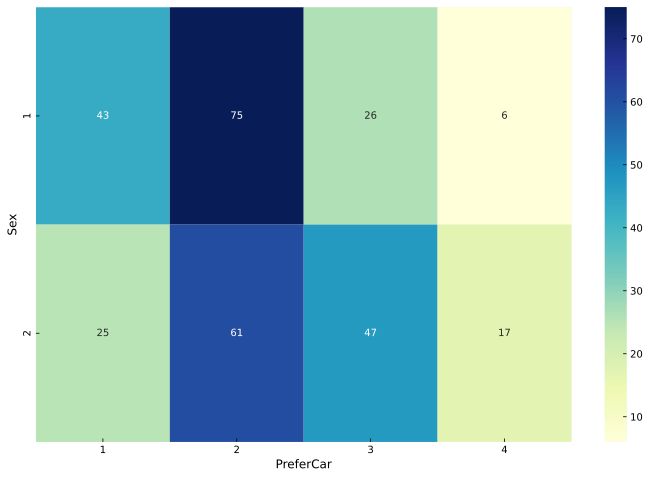

In [ ]:
#Visualize the contingency table
plt.figure(figsize=(12,8)) 
sns.heatmap(contigency, annot=True, cmap="YlGnBu")

In [ ]:
from scipy.stats import chi2_contingency

c, p, dof, expected = chi2_contingency(contigency)
print('p value = ', p)

p value =  0.0005555699275518034


p value is nearly zero, so we reject $H_0$.

That means, we accept $H_1$, which says the two variable "Sex" and "PreferCar" are not independent.

---

# Task 3

You can find and download a dataset there:
https://www.kaggle.com/russellyates88/suicide-rates-overview-1985-to-2016


1) For any country (you are free to choose any of the presented) 
 *  Visualize a feature **suicides_no** considering other features: **sex**, **age** (or **generation**) and year;
 *  Check whether there is statistical difference for suicide number between these groups: men / women. If it is found, can we claim that people of certain sex are more prone to suicides or do we need additional information?

2) For 2016: divide countries into 3-4 groups according to the values of the **gdp_per_capita** feature (use statistical characteristics to determine how to divide the data into groups), check if the suicides / 100k pop indicator differs in these groups. Do not forget that for each country you have several values and they need to be aggregated or checked for each group separately.

In [ ]:
data_frame = pd.read_csv('data/master.csv')
data_frame.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


In [ ]:
data_frame.describe()

,year,suicides_no,population,suicides/100k pop,HDI for year,gdp_per_capita ($)
count,27820.000000,27820.000000,2.782000e+04,27820.000000,8364.000000,27820.000000
mean,2001.258375,242.574407,1.844794e+06,12.816097,0.776601,16866.464414
std,8.469055,902.047917,3.911779e+06,18.961511,0.093367,18887.576472
min,1985.000000,0.000000,2.780000e+02,0.000000,0.483000,251.000000
25%,1995.000000,3.000000,9.749850e+04,0.920000,0.713000,3447.000000
50%,2002.000000,25.000000,4.301500e+05,5.990000,0.779000,9372.000000
75%,2008.000000,131.000000,1.486143e+06,16.620000,0.855000,24874.000000
max,2016.000000,22338.000000,4.380521e+07,224.970000,0.944000,126352.000000


In [ ]:
data_frame.isna().sum()

country                   0
year                      0
sex                       0
age                       0
suicides_no               0
population                0
suicides/100k pop         0
country-year              0
HDI for year          19456
 gdp_for_year ($)         0
gdp_per_capita ($)        0
generation                0
dtype: int64

In [ ]:
data_frame['HDI for year'].describe()

count    8364.000000
mean        0.776601
std         0.093367
min         0.483000
25%         0.713000
50%         0.779000
75%         0.855000
max         0.944000
Name: HDI for year, dtype: float64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


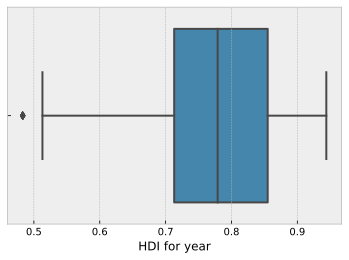

In [ ]:
sns.boxplot('HDI for year', data = data_frame)

Box plot seems normal to me, the most HDI for year in between ~0.71 and ~0.85

But we won't work with this feature now.

## 1) Visualize for Hungary

In [ ]:
# I will choose Hungary
(data_frame['country'] == 'Hungary').sum()

310

In [ ]:
# from pandas.io.formats.format import DataFrameRenderer
# Remove all rows that are not Hungary
df = data_frame[data_frame['country'] == 'Hungary']

In [ ]:
# Re-index the new dataframe
df.index = range(310)

In [ ]:
df.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Hungary,1991,male,75+ years,333,188235,176.91,Hungary1991,NaN,"34,748,508,332",3561,G.I. Generation
1,Hungary,1991,male,35-54 years,1271,1420586,89.47,Hungary1991,NaN,"34,748,508,332",3561,Boomers
2,Hungary,1991,male,55-74 years,751,874916,85.84,Hungary1991,NaN,"34,748,508,332",3561,Silent
3,Hungary,1991,female,75+ years,263,363039,72.44,Hungary1991,NaN,"34,748,508,332",3561,G.I. Generation
4,Hungary,1991,male,25-34 years,364,663374,54.87,Hungary1991,NaN,"34,748,508,332",3561,Boomers


### Visualization the number of suicides to other features

#### Age

In [ ]:
df['age'].unique()

array(['75+ years', '35-54 years', '55-74 years', '25-34 years',
       '15-24 years', '5-14 years'], dtype=object)

In [ ]:
age_df = df.groupby(['age'])['suicides_no'].sum()

In [ ]:
# Create a dataframe, and order it descending by the number of suicides
age_df = age_df.copy().reset_index().sort_values(by = 'suicides_no', ascending = False)

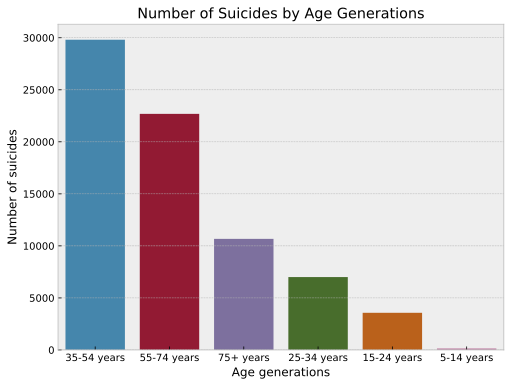

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x = 'age', y = 'suicides_no', data = age_df)
plt.title('Number of Suicides by Age Generations')
plt.xlabel('Age generations')
plt.ylabel('Number of suicides')
plt.show()

We can clearly see that the most suicides commited in the age between 35-54.

The lowest number is in age 5-14 group.

#### Sex

In [ ]:
df['sex'].unique()

array(['male', 'female'], dtype=object)

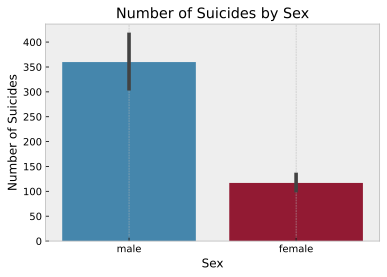

In [ ]:
sns.barplot(x = 'sex', y = 'suicides_no', data = df)
plt.grid(b = None)
plt.title('Number of Suicides by Sex')
plt.xlabel('Sex')
plt.ylabel('Number of Suicides')
plt.show()

The suicides number of male are about three times higher then of female.

In [ ]:
df_age_sex = df.groupby(['age', 'sex'])['suicides_no'].sum()

In [ ]:
df_age_sex = df_age_sex.copy().reset_index()

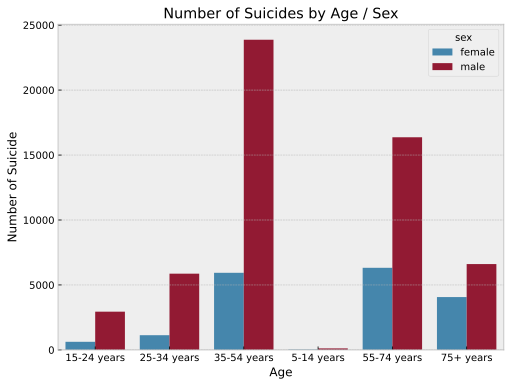

In [ ]:
plt.figure(figsize = (8, 6))
sns.barplot(x = 'age', y = 'suicides_no', hue = 'sex', data = df_age_sex)
plt.title('Number of Suicides by Age / Sex')
plt.xlabel('Age')
plt.ylabel('Number of Suicide')
plt.show()

In every generation and every year, the male suicide numbers are greater then female.

Let's check, which generation has the highest / lowest ratio.

In [ ]:
# Calculate the female / male suicide ratio
df_suicide_sex_ratio = []

for generation in df_age_sex['age'].unique():
    # Calculate in each generation the female and male suicides numbers
    female_no = df_age_sex.loc[(df_age_sex['sex'] == 'female') & (df_age_sex['age'] == generation), ['suicides_no']].suicides_no
    male_no = df_age_sex.loc[(df_age_sex['sex'] == 'male') & (df_age_sex['age'] == generation), ['suicides_no']].suicides_no

    # Append the list with the ratios
    df_suicide_sex_ratio.append(
        {
            'age': generation,
            'ratio': int(female_no) / int(male_no)
        }
    )


In [ ]:
# Create a DataFrame from it
df_suicide_sex_ratio = pd.DataFrame(df_suicide_sex_ratio)

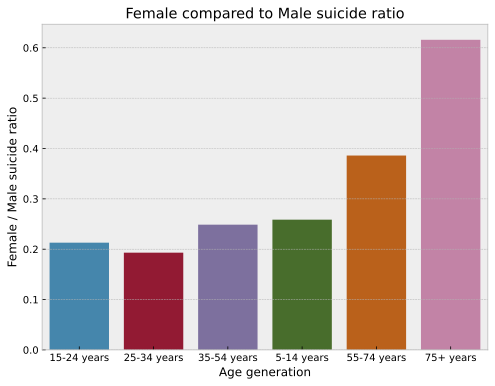

In [ ]:
plt.figure(figsize = (8, 6))
sns.barplot(x = 'age', y = 'ratio', data = df_suicide_sex_ratio)
plt.title('Female compared to Male suicide ratio')
plt.xlabel('Age generation')
plt.ylabel('Female / Male suicide ratio')
plt.show()

Check whether there is statistical difference for suicide number between female and male.

Two sample t-test

- $H_0$: means are equal
- $H_1$: means are not equal

In [ ]:
df_hungary_f = df[df['sex'] == 'female']
df_hungary_m = df[df['sex'] == 'male']

In [ ]:
column_1 = df_hungary_f.groupby('year')['suicides_no'].sum()
column_2 = df_hungary_m.groupby('year')['suicides_no'].sum()
st.ttest_ind(column_1, column_2)

Ttest_indResult(statistic=-15.101762844306174, pvalue=2.8985149189966936e-20)

In [ ]:
column_1 = df[df['sex'] == 'female']['suicides_no']
column_2 = df[df['sex'] == 'male']['suicides_no']
st.ttest_ind(column_1, column_2)

Ttest_indResult(statistic=-8.581728772149637, pvalue=4.676719330858484e-16)

Both $p$ value is nearly 0, so we

reject $H_0$: Equal means for genders in suicide numbers.

accept $H_1$: The two groups (female / male) does not have an equal mean in suicides numbers.

#### Year

In [ ]:
year_df = df.groupby(['year'])['suicides_no'].sum()
year_df = year_df.copy().reset_index()
year_df.head()

,year,suicides_no
0,1991,3993
1,1992,4000
2,1993,3694
3,1994,3625
4,1995,3366


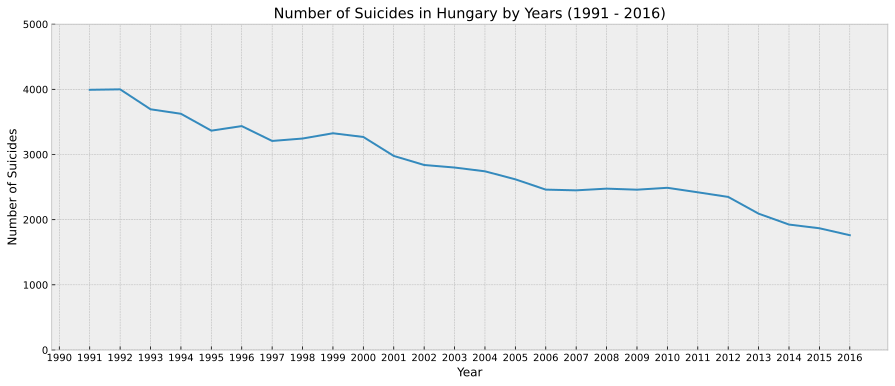

In [ ]:
plt.figure(figsize = (15, 6))
# sns.barplot(x = 'year', y = 'suicides_no', data = year_df, edgecolor='0', facecolor=(1, 1, 1, 1))
sns.lineplot(x = 'year', y = 'suicides_no', data = year_df)
plt.title('Number of Suicides in Hungary by Years (1991 - 2016)')
plt.xlabel('Year')
plt.ylabel('Number of Suicides')
plt.ylim(0, 5000)
plt.xticks(range(1990, 2017))
plt.show()


Analyze the previous datas with sex included.

In [ ]:
# Count all suicides in years by genders. (age generation is not a point here)

df_year_sex = df.groupby(['year', 'sex'])['suicides_no'].sum()
df_year_sex = pd.DataFrame(df_year_sex)
df_year_sex.head()

suicides_no
year sex                
1991 female         1113
     male           2880
1992 female         1061
     male           2939
1993 female          979

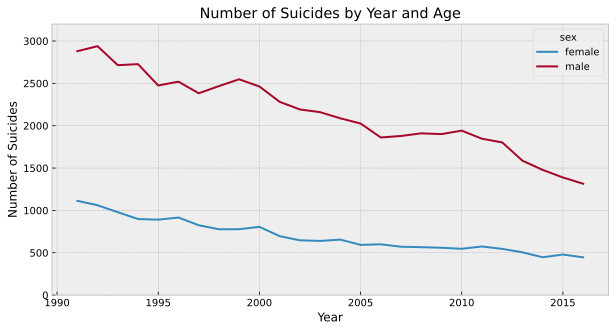

In [ ]:
plt.figure(figsize = (10, 5))
sns.lineplot(x = 'year', y = 'suicides_no', hue = 'sex', data = df_year_sex)
plt.xlabel('Year')
plt.ylabel('Number of Suicides')
plt.title('Number of Suicides by Year and Age')
plt.ylim(0, 3200)
plt.show()

The number of suicides are descending from 1991 to 2016.

The highest number was in 1991, the lowest in 2016.

## 2) Countries in 2016

In [ ]:
# Work the datas from only 2016.
df_2016 = data_frame[data_frame['year'] == 2016]

In [ ]:
df_2016

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
1248,Armenia,2016,male,75+ years,12,61956,19.37,Armenia2016,NaN,"10,546,135,160",3788,Silent
1249,Armenia,2016,male,55-74 years,16,237813,6.73,Armenia2016,NaN,"10,546,135,160",3788,Boomers
1250,Armenia,2016,male,35-54 years,16,350633,4.56,Armenia2016,NaN,"10,546,135,160",3788,Generation X
1251,Armenia,2016,male,15-24 years,5,202220,2.47,Armenia2016,NaN,"10,546,135,160",3788,Millenials
1252,Armenia,2016,female,75+ years,2,102414,1.95,Armenia2016,NaN,"10,546,135,160",3788,Silent
...,...,...,...,...,...,...,...,...,...,...,...,...
25307,Thailand,2016,female,75+ years,69,1589015,4.34,Thailand2016,NaN,"411,755,164,833",6713,Silent
25308,Thailand,2016,female,55-74 years,222,6049756,3.67,Thailand2016,NaN,"411,755,164,833",6713,Boomers
25309,Thailand,2016,female,35-54 years,375,10629684,3.53,Thailand2016,NaN,"411,755,164,833",6713,Generation X
25310,Thailand,2016,female,25-34 years,116,4702656,2.47,Thailand2016,NaN,"411,755,164,833",6713,Millenials


In [ ]:
# Let's see some information.
df_2016['gdp_per_capita ($)'].describe()

count      160.000000
mean     25665.125000
std      21243.939779
min       3788.000000
25%      10432.500000
50%      14595.000000
75%      47259.000000
max      64708.000000
Name: gdp_per_capita ($), dtype: float64

I will divide countries into 4 groups, that will be the quantiles.
- Lower than 25%
- Between 25% and 50%
- Between 50% and 75%
- Greater than 75%

In [ ]:
print(df_2016['country'].unique())
print(len(df_2016['country'].unique()))

['Armenia' 'Austria' 'Croatia' 'Cyprus' 'Czech Republic' 'Grenada'
 'Hungary' 'Iceland' 'Lithuania' 'Mauritius' 'Mongolia' 'Netherlands'
 'Qatar' 'Romania' 'Sweden' 'Thailand']
16


There is 16 country in the dataset.

Check that every country has only one value of 'gdp_per_capita ($)'

In [ ]:
gdp_per_capita_per_country = []
for country in df_2016['country'].unique():
    print(len(gdp_per_capita_per_country))
    gdp_per_capita_per_country = []
    #print(df_2016[df_2016['country'] == country]['gdp_per_capita ($)'])
    if df_2016[df_2016['country'] == country]['gdp_per_capita ($)'] not in gdp_per_capita_per_country:
      gdp_per_capita_per_country.append(df_2016[df_2016['country'] == country]['gdp_per_capita ($)'])

0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


Except the first (initialized list), all list len is equal to one, which means all country have only one value in the 'gdp_per_capita ($)' feature.

In [ ]:
df_gdp_per_capita = []

for country in df_2016['country'].unique():
  df_gdp_per_capita.append(
      {
          'country': country,
          'gdp_per_capita': int(df_2016[df_2016['country'] == country]['gdp_per_capita ($)'].unique())
      }
  )

df_gdp_per_capita = pd.DataFrame(df_gdp_per_capita)
df_gdp_per_capita

,country,gdp_per_capita
0,Armenia,3788
1,Austria,46976
2,Croatia,12905
3,Cyprus,25098
4,Czech Republic,19505
5,Grenada,10838
6,Hungary,13448
7,Iceland,64708
8,Lithuania,15742
9,Mauritius,10570


In [ ]:
df_suicide_100k_pop = []

for generation in df_2016['age'].unique():
    for country in df_2016['country'].unique():
      # print(country, generation)
      # print(df_2016['suicides/100k pop'][(df_2016['country'] == country) & (df_2016['age'] == generation) & (df_2016['sex'] == 'female')])
      # print(df_2016['suicides/100k pop'][(df_2016['country'] == country) & (df_2016['age'] == generation) & (df_2016['sex'] == 'male')])
      # print('SUMMMM:', (df_2016['suicides/100k pop'][(df_2016['country'] == country) & (df_2016['age'] == generation)]).sum())
      # print('GDP:', df_2016['gdp_per_capita ($)'][df_2016['country'] == country].unique())
      # print('\n\n')

      df_suicide_100k_pop.append(
          {
              'country': country,
              'age': generation,
           
              # SUM of the female + male suicide ratio / 100k population
              'suicides/100k pop': (float(df_2016['suicides/100k pop'][(df_2016['country'] == country) & (df_2016['age'] == generation) & (df_2016['sex'] == 'female')]) +
               float(df_2016['suicides/100k pop'][(df_2016['country'] == country) & (df_2016['age'] == generation) & (df_2016['sex'] == 'male')])) / 2,
           
              'gdp_per_capita ($)': int(df_2016['gdp_per_capita ($)'][df_2016['country'] == country].unique())
          }
      )

In [ ]:
df_suicide_100k_pop = pd.DataFrame(df_suicide_100k_pop)
df_suicide_100k_pop[:20]

,country,age,suicides/100k pop,gdp_per_capita ($)
0,Armenia,75+ years,10.660,3788
1,Austria,75+ years,40.825,46976
2,Croatia,75+ years,46.785,12905
3,Cyprus,75+ years,4.165,25098
4,Czech Republic,75+ years,28.180,19505
5,Grenada,75+ years,0.000,10838
6,Hungary,75+ years,54.935,13448
7,Iceland,75+ years,5.730,64708
8,Lithuania,75+ years,56.005,15742
9,Mauritius,75+ years,9.520,10570


In [ ]:
q_25 = df_suicide_100k_pop['gdp_per_capita ($)'].quantile(0.25)
q_50 = df_suicide_100k_pop['gdp_per_capita ($)'].quantile(0.50)
q_75 = df_suicide_100k_pop['gdp_per_capita ($)'].quantile(0.75)

print(q_25, q_50, q_75)



10432.5 14595.0 47259.0


In [ ]:
# Check the dataset with the gdp_per_capita lower than quantile 0.25.
df_suicide_100k_pop[df_suicide_100k_pop['gdp_per_capita ($)'] <= q_25]

,country,age,suicides/100k pop,gdp_per_capita ($)
0,Armenia,75+ years,10.660,3788
10,Mongolia,75+ years,15.475,4145
13,Romania,75+ years,17.800,10020
15,Thailand,75+ years,8.930,6713
16,Armenia,55-74 years,4.340,3788
26,Mongolia,55-74 years,13.105,4145
29,Romania,55-74 years,17.140,10020
31,Thailand,55-74 years,8.885,6713
32,Armenia,35-54 years,2.650,3788
42,Mongolia,35-54 years,18.750,4145


### Visualize Suicide / 100K Population

#### Compare countries in the same GDP group

**These plots represent the Suicide / 100k Population ratio within the same GDP groups**

Text(0, 0.5, 'Suicides / 100k Population Ratio')

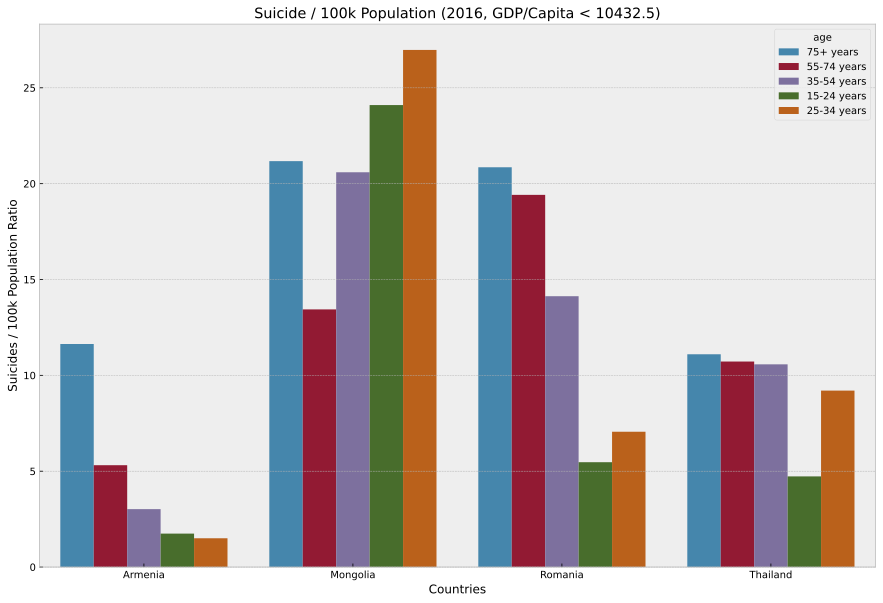

In [ ]:
plt.figure(figsize = (15, 10))
sns.barplot(x = 'country', y = 'suicides/100k pop', hue = 'age', data = df_suicide_100k_pop[df_suicide_100k_pop['gdp_per_capita ($)'] <= q_25])
plt.title(f'Suicide / 100k Population (2016, GDP/Capita < {q_25})')
plt.xlabel('Countries')
plt.ylabel('Suicides / 100k Population Ratio')

Text(0, 0.5, 'Suicides / 100k Population Ratio')

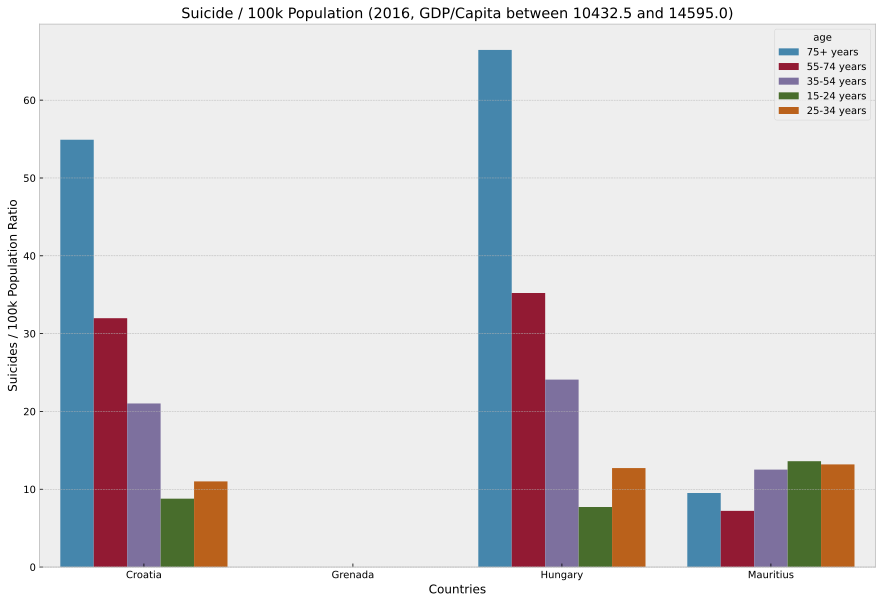

In [ ]:
plt.figure(figsize = (15, 10))
sns.barplot(x = 'country', y = 'suicides/100k pop', hue = 'age', data = df_suicide_100k_pop[df_suicide_100k_pop['gdp_per_capita ($)'].between(q_25, q_50)])
plt.title(f'Suicide / 100k Population (2016, GDP/Capita between {q_25} and {q_50})')
plt.xlabel('Countries')
plt.ylabel('Suicides / 100k Population Ratio')

Text(0, 0.5, 'Suicides / 100k Population Ratio')

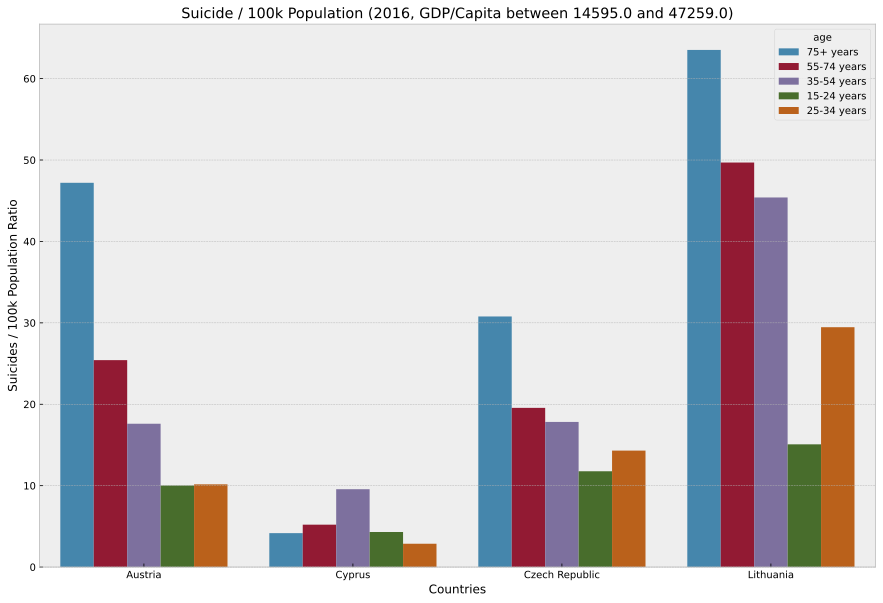

In [ ]:
plt.figure(figsize = (15, 10))
sns.barplot(x = 'country', y = 'suicides/100k pop', hue = 'age', data = df_suicide_100k_pop[df_suicide_100k_pop['gdp_per_capita ($)'].between(q_50, q_75)])
plt.title(f'Suicide / 100k Population (2016, GDP/Capita between {q_50} and {q_75})')
plt.xlabel('Countries')
plt.ylabel('Suicides / 100k Population Ratio')

Text(0, 0.5, 'Suicides / 100k Population Ratio')

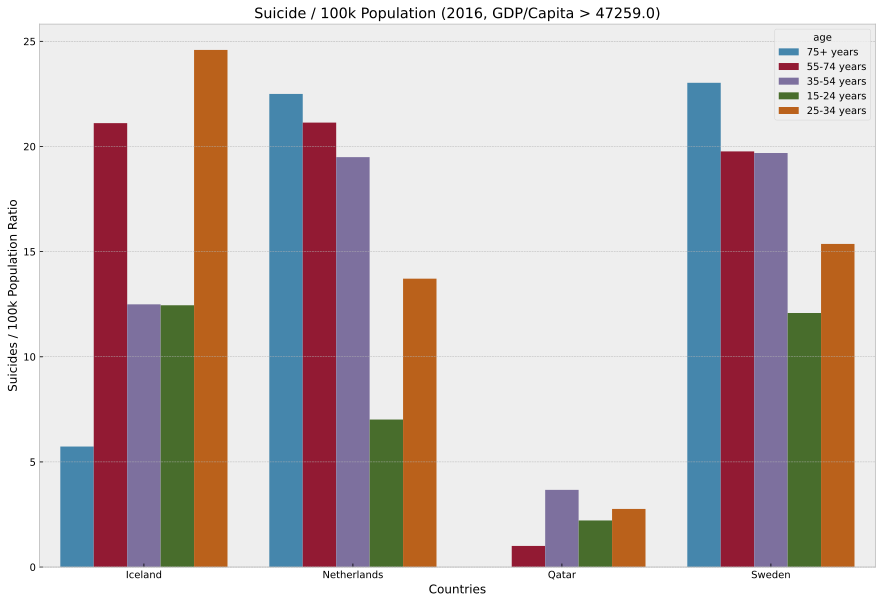

In [ ]:
plt.figure(figsize = (15, 10))
sns.barplot(x = 'country', y = 'suicides/100k pop', hue = 'age', data = df_suicide_100k_pop[df_suicide_100k_pop['gdp_per_capita ($)'] > q_75])
plt.title(f'Suicide / 100k Population (2016, GDP/Capita > {q_75})')
plt.xlabel('Countries')
plt.ylabel('Suicides / 100k Population Ratio')

#### Compare countries divided by GDP

In [ ]:
suicide = []

suicide.append(df_suicide_100k_pop['suicides/100k pop'][df_suicide_100k_pop['gdp_per_capita ($)'] < q_25].mean())
suicide.append(df_suicide_100k_pop['suicides/100k pop'][df_suicide_100k_pop['gdp_per_capita ($)'].between(q_25, q_50)].mean())
suicide.append(df_suicide_100k_pop['suicides/100k pop'][df_suicide_100k_pop['gdp_per_capita ($)'].between(q_50, q_75)].mean())
suicide.append(df_suicide_100k_pop['suicides/100k pop'][df_suicide_100k_pop['gdp_per_capita ($)'] > q_75].mean())

In [ ]:
print(suicide)

[10.465, 13.855, 18.8465, 10.518249999999998]


In [ ]:
gpd_quantiles = [f'<{q_25}', f'{q_25} <= GDP <= {q_50}', f'{q_50} <= GDP <= {q_75}', f'>{q_75}']

In [ ]:
df_suicide_100k_pop_gdp = []
for i in range(4):
  df_suicide_100k_pop_gdp.append(
      {
          'suicide': suicide[i],
          'gdp_per_capita ($)': gpd_quantiles[i]
      }
  )
df_suicide_100k_pop_gdp = pd.DataFrame(df_suicide_100k_pop_gdp)

In [ ]:
df_suicide_100k_pop_gdp

,suicide,gdp_per_capita ($)
0,10.46500,<10432.5
1,13.85500,10432.5 <= GDP <= 14595.0
2,18.84650,14595.0 <= GDP <= 47259.0
3,10.51825,>47259.0


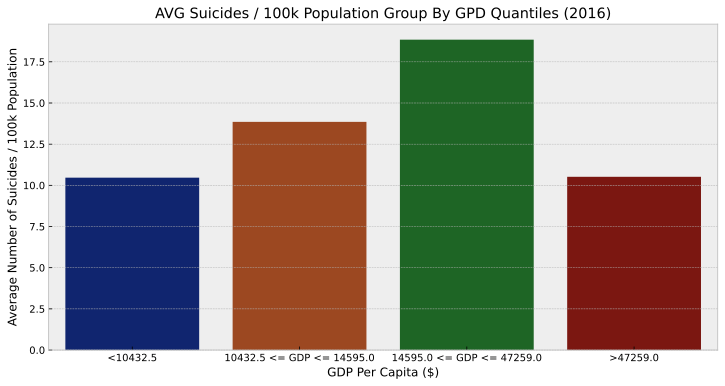

In [ ]:
plt.figure(figsize = (12, 6))
sns.barplot(x = 'gdp_per_capita ($)', y = 'suicide', data = df_suicide_100k_pop_gdp, palette = 'dark')
plt.title('AVG Suicides / 100k Population Group By GPD Quantiles (2016)')
plt.xlabel('GDP Per Capita ($)')
plt.ylabel('Average Number of Suicides / 100k Population')
# plt.grid(visible = False)
plt.show()

Finally, we can say, that the lowest number of suicide / 100k population is in the countries that  has interestingly the highest and lowest GDP per Capita.

The highest rate are in the countries where the GDP per Capita is between 14595 and 47259.

In [ ]:
gdp_per_capita_means = []
gdp_per_capita_means.append(df_2016['gdp_per_capita ($)'][df_2016['gdp_per_capita ($)'] < q_25].mean())
gdp_per_capita_means.append(df_2016['gdp_per_capita ($)'][df_2016['gdp_per_capita ($)'].between(q_25, q_50)].mean())
gdp_per_capita_means.append(df_2016['gdp_per_capita ($)'][df_2016['gdp_per_capita ($)'].between(q_50, q_75)].mean())
gdp_per_capita_means.append(df_2016['gdp_per_capita ($)'][df_2016['gdp_per_capita ($)'] > q_75].mean())
gdp_per_capita_means

[6166.5, 11940.25, 26830.25, 57723.5]

In [ ]:
suicide_hypo = pd.DataFrame()
suicide_hypo['suicide_no'] = suicide
suicide_hypo['gdp_mean'] = gdp_per_capita_means
suicide_hypo

,suicide_no,gdp_mean
0,10.46500,6166.50
1,13.85500,11940.25
2,18.84650,26830.25
3,10.51825,57723.50


In [ ]:
suicide_hypo['suicide_no'].corr(suicide_hypo['gdp_mean'])

-0.12821386005502236

The correlation is -0.1282, so the correlation is a weak negative relationship between the number of suicide / 100k pop and gdp_capita divided into 4 groups.

So we can say the suicide number / 100k population is independent with gdp per capita.